# TC 5033
## Deep Learning
## Convolutional Neural Networks
<br>

#### Activity 2b: Building a CNN for CIFAR10 dataset with PyTorch
<br>

- Objective

    The main goal of this activity is to further your understanding of Convolutional Neural Networks (CNNs) by building one using PyTorch. You will apply this architecture to the famous CIFAR10 dataset, taking what you've learned from the guide code that replicated the Fully Connected model in PyTorch (Activity 2a).

- Instructions
    This activity requires submission in teams of 5 or 6 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Understand the Guide Code: Review the guide code from Activity 2a that implemented a Fully Connected model in PyTorch. Note how PyTorch makes it easier to implement neural networks.

    Familiarize Yourself with CNNs: Take some time to understand their architecture and the rationale behind using convolutional layers.

    Prepare the Dataset: Use PyTorch's DataLoader to manage the dataset. Make sure the data is appropriately preprocessed for a CNN.

    Design the CNN Architecture: Create a new architecture that incorporates convolutional layers. Use PyTorch modules like nn.Conv2d, nn.MaxPool2d, and others to build your network.

    Training Loop and Backpropagation: Implement the training loop, leveraging PyTorch’s autograd for backpropagation. Keep track of relevant performance metrics.

    Analyze and Document: Use Markdown cells to explain your architectural decisions, performance results, and any challenges you faced. Compare this model with your previous Fully Connected model in terms of performance and efficiency.

- Evaluation Criteria

    - Understanding of CNN architecture and its application to the CIFAR10 dataset
    - Code Readability and Comments
    - Appropriateness and efficiency of the chosen CNN architecture
    - Correct implementation of Traning Loop and Accuracy Function
    - Model's performance metrics on the CIFAR10 dataset (at least 65% accuracy)
    - Quality of Markdown documentation

- Submission

Submit via Canvas your Jupyter Notebook with the CNN implemented in PyTorch. Your submission should include well-commented code and Markdown cells that provide a comprehensive view of your design decisions, performance metrics, and learnings.

### Team:
- Martín Jurado .................................................. A01795568
- Lineth Guerra .................................................. A01795639
- Erick Eduardo Betancourt ........................... A01795545
- Luis Alejandro González Castellanos ................. A01795481
- Jesus Armando Anaya Orozco .................... A01795464

In [38]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
#only if you have jupyterthemes
#from jupyterthemes import jtplot
#jtplot.style()

### Download Cifar10 dataset

In [2]:
torch.cuda.is_available()

True

In [3]:
DATA_PATH = './cifar10'
NUM_TRAIN = 50000
NUM_VAL = 5000
NUM_TEST = 5000
MINIBATCH_SIZE = 64

transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

# Train dataset
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_cifar)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
#Validation set
cifar10_val = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                           transform=transform_cifar)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))
#Test set
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True, 
                            transform=transform_cifar)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL, len(cifar10_test))))

100%|██████████| 170498071/170498071 [00:01<00:00, 107483987.39it/s]


Extracting /data/cifar10/cifar-10-python.tar.gz to /data/cifar10
Files already downloaded and verified
Files already downloaded and verified


In [4]:
cifar10_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /data/cifar10
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.261])
           )

In [5]:
train_loader.batch_size

64

In [ ]:
for i, (x, y) in enumerate(train_loader):
    print(x, y)

### Using  GPUs

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


### Mostrar imágenes

La imagen muestreada representa un: ship


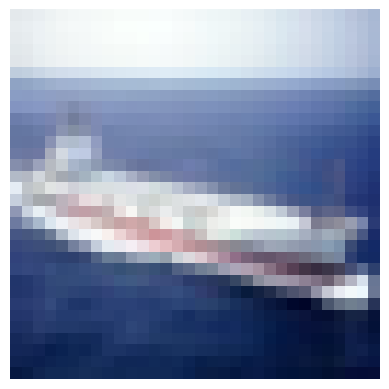

In [8]:
classes = test_loader.dataset.classes
def plot_figure(image):
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)


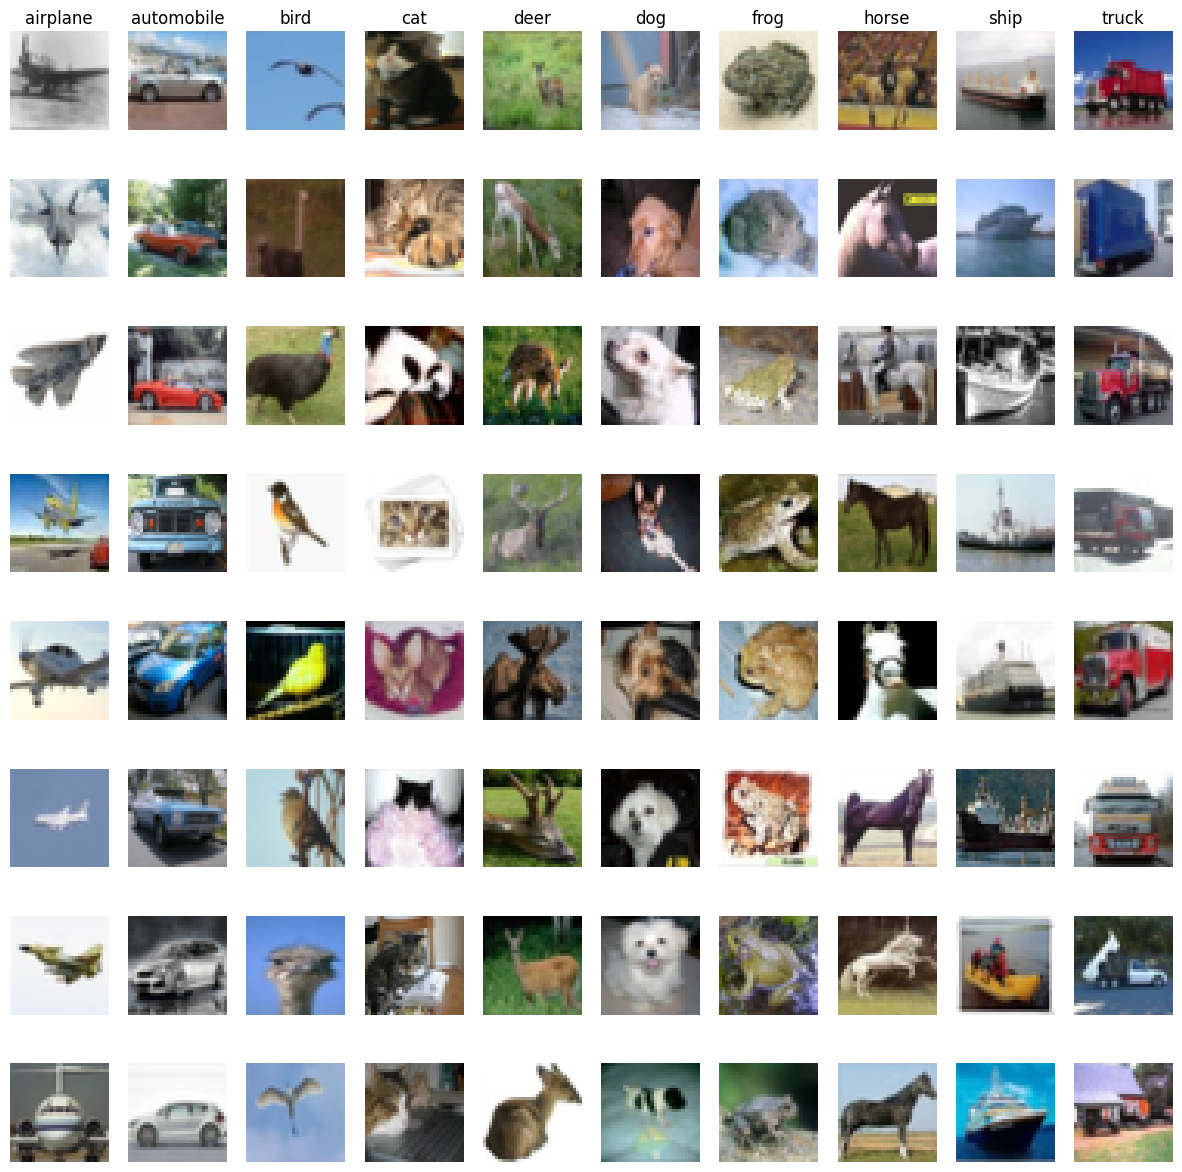

In [9]:
def plot_cifar10_grid():
    classes = test_loader.dataset.classes
    total_samples = 8
    plt.figure(figsize=(15,15))
    for label, sample in enumerate(classes):
        class_idxs = np.flatnonzero(label == np.array(test_loader.dataset.targets))
        sample_idxs = np.random.choice(class_idxs, total_samples, replace = False)
        for i, idx in enumerate(sample_idxs):
            plt_idx = i*len(classes) + label + 1
            plt.subplot(total_samples, len(classes), plt_idx)
            plt.imshow(test_loader.dataset.data[idx])
            plt.axis('off')
            
            if i == 0: plt.title(sample)
    plt.show()

plot_cifar10_grid() 

### Calcular accuracy


In [11]:
def accuracy(model, loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for x, y in loader:
            x, y = x.to(device), y.to(device)  # Move both to the device at once
            scores = model(x)  # Forward pass
            _, predictions = scores.max(1)  # Get the index of the max log-probability
            correct += (predictions == y).sum().item()  # Accumulate correct predictions
            total += y.size(0)  # Accumulate total samples (batch size)
    
    return correct / total  # Return overall accuracy


### Loop de entrenamiento

In [40]:
def train(model, optimiser, epochs=100):
    # Transfer model to the device
    model = model.to(device=device)
    
    # Lists to store loss and accuracy for each epoch
    loss_values = []
    val_acc_values = []

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        
        # Loop over batches
        for x, y in train_loader:
            # Transfer data to device
            x = x.to(device)
            y = y.to(device)
            
            # Forward pass
            scores = model(x)
            loss = F.cross_entropy(scores, y)  # Compute loss
            
            # Backpropagation and optimization
            optimiser.zero_grad()  # Clear previous gradients
            loss.backward()  # Compute new gradients
            optimiser.step()  # Update weights
            
            # Accumulate loss
            running_loss += loss.item()

        # Calculate average loss over all batches
        avg_loss = running_loss / len(train_loader)
        loss_values.append(avg_loss)

        # Calculate training and validation accuracy
        train_acc = accuracy(model, train_loader)  # Compute training accuracy
        val_acc = accuracy(model, val_loader)  # Compute validation accuracy
        val_acc_values.append(val_acc)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}')
    
    # Compute test accuracy after training
    test_acc = accuracy(model, test_loader)
    print(f'Test Accuracy: {test_acc:.4f}')
    
    # Plotting the loss and validation accuracy
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(14, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss_values, label='Training Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_acc_values, label='Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()



### Linear model

In [13]:
# To do: Use PyTorch to create a linear model to have an initial baseline model
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*32*32, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        return self.layers(x)

    
model1 = LinearModel()
lr = 1e-4
epochs = 20
optimiser = torch.optim.Adam(model1.parameters(), lr=lr)

In [14]:
# Setup random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

train(model1, optimiser, epochs)

Epoch 1/20, Loss: 1.6075, Train Accuracy: 0.4819, Val Accuracy: 0.4734
Epoch 2/20, Loss: 1.1012, Train Accuracy: 0.5293, Val Accuracy: 0.5020
Epoch 3/20, Loss: 1.5437, Train Accuracy: 0.5620, Val Accuracy: 0.5196
Epoch 4/20, Loss: 1.5733, Train Accuracy: 0.5932, Val Accuracy: 0.5362
Epoch 5/20, Loss: 1.3911, Train Accuracy: 0.6095, Val Accuracy: 0.5266
Epoch 6/20, Loss: 1.8692, Train Accuracy: 0.6379, Val Accuracy: 0.5452
Epoch 7/20, Loss: 0.9313, Train Accuracy: 0.6598, Val Accuracy: 0.5498
Epoch 8/20, Loss: 1.1399, Train Accuracy: 0.6747, Val Accuracy: 0.5500
Epoch 9/20, Loss: 0.7457, Train Accuracy: 0.6863, Val Accuracy: 0.5452
Epoch 10/20, Loss: 0.9508, Train Accuracy: 0.7152, Val Accuracy: 0.5556
Epoch 11/20, Loss: 1.0732, Train Accuracy: 0.7321, Val Accuracy: 0.5522
Epoch 12/20, Loss: 0.9904, Train Accuracy: 0.7344, Val Accuracy: 0.5472
Epoch 13/20, Loss: 1.0491, Train Accuracy: 0.7538, Val Accuracy: 0.5490
Epoch 14/20, Loss: 1.2632, Train Accuracy: 0.7721, Val Accuracy: 0.5592
E

### Sequential CNN

In [43]:
# To do: Use PyTorch to implement a CNN model, accuracy should be better than 
#the linear model

input_channels = 3
hidden_1 = 32
hidden_2 = 64
hidden_3 = 128

class ModelCNNProposal1(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers (Sequential block)
        self.conv_layers = nn.Sequential(
            # First conv block: 32x32x3 -> 32x32x32
            nn.Conv2d(in_channels=input_channels, out_channels=hidden_1, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32 -> 16x16
            
            # Second conv block: 16x16x32 -> 16x16x64
            nn.Conv2d(in_channels=hidden_1, out_channels=hidden_2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16 -> 8x8
            
            # Third conv block: 8x8x64 -> 8x8x128
            nn.Conv2d(in_channels=hidden_2, out_channels=hidden_3, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 8x8 -> 4x4
        )

        # Fully connected layers (Sequential block)
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  # Flatten output from conv layers
            nn.Linear(128 * 4 * 4, 512),  # Fully connected with 512 units
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(512, 256),  # 256 hidden units
            nn.ReLU(),
            nn.Linear(256, 10)  # Output layer: 10 classes for CIFAR-10
        )

    def forward(self, x):
        # Pass through convolutional layers
        x = self.conv_layers(x)
        
        # Pass through fully connected layers
        x = self.fc_layers(x)
        
        return x


In [45]:
# Grid search over learning rates

def grid_search(learning_rates, model_class):
    epochs = 10

    # List to store results
    results = []
    history = {'lr': [], 'epoch': [], 'loss': [], 'val_accuracy': []}  # To store values for plotting

    # Grid search over all combinations of learning rates
    for index, lr in enumerate(learning_rates):
        print(f"Training [{index+1}/{len(learning_rates)}]: lr={lr:.0e}")
        
        # Setup random seed for reproducibility
        torch.manual_seed(42)
        np.random.seed(42)

        # Initialize the model
        model = model_class().to(device)

        # Use Adam optimizer with the current learning rate
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Loss function
        criterion = nn.CrossEntropyLoss()

        # Train model
        best_val_accuracy = 0
        
        for epoch in range(epochs):
            model.train()
            loss_values = []
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                loss_values.append(loss.item())
            running_loss = np.mean(loss_values)
            
            # Evaluate on validation set
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_accuracy = correct / total

            print(f"Epoch [{epoch+1}], Loss: {running_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

            # Keep track of the best validation accuracy for this combination
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
            
            # Store history for plotting
            history['lr'].append(lr)
            history['epoch'].append(epoch + 1)
            history['loss'].append(running_loss)
            history['val_accuracy'].append(val_accuracy)

        # Store the result for this combination of hyperparameters
        results.append({
            'lr': lr,
            'val_accuracy': best_val_accuracy
        })

    # Find the best combination of hyperparameters
    best_result = max(results, key=lambda x: x['val_accuracy'])
    return best_result, history


In [47]:
# Define the grid of hyperparameters
learning_rates = [1e-4, 1e-3, 1e-2]

best_result, history = grid_search(learning_rates, ModelCNNProposal1)

print(f"Best Hyperparameters for the model ModelCNNProposal1: {best_result['lr']:.0e}")

Training [1/3]: lr=1e-04
Epoch [1], Loss: 1.4486, Val Accuracy: 0.5936
Epoch [2], Loss: 1.0654, Val Accuracy: 0.6616
Epoch [3], Loss: 0.9232, Val Accuracy: 0.7026
Epoch [4], Loss: 0.8373, Val Accuracy: 0.7216
Epoch [5], Loss: 0.7602, Val Accuracy: 0.7222
Epoch [6], Loss: 0.7042, Val Accuracy: 0.7326
Epoch [7], Loss: 0.6517, Val Accuracy: 0.7512
Epoch [8], Loss: 0.6068, Val Accuracy: 0.7636
Epoch [9], Loss: 0.5654, Val Accuracy: 0.7402
Epoch [10], Loss: 0.5286, Val Accuracy: 0.7632
Training [2/3]: lr=1e-03
Epoch [1], Loss: 1.3331, Val Accuracy: 0.6404
Epoch [2], Loss: 0.9869, Val Accuracy: 0.6914
Epoch [3], Loss: 0.8472, Val Accuracy: 0.7300
Epoch [4], Loss: 0.7619, Val Accuracy: 0.7362
Epoch [5], Loss: 0.6845, Val Accuracy: 0.7572
Epoch [6], Loss: 0.6244, Val Accuracy: 0.7668
Epoch [7], Loss: 0.5720, Val Accuracy: 0.7704
Epoch [8], Loss: 0.5225, Val Accuracy: 0.7892
Epoch [9], Loss: 0.4715, Val Accuracy: 0.7576
Epoch [10], Loss: 0.4321, Val Accuracy: 0.7854
Training [3/3]: lr=1e-02
Epo

Showing the history of the training for the best learning rate for the model ModelCNNProposal1


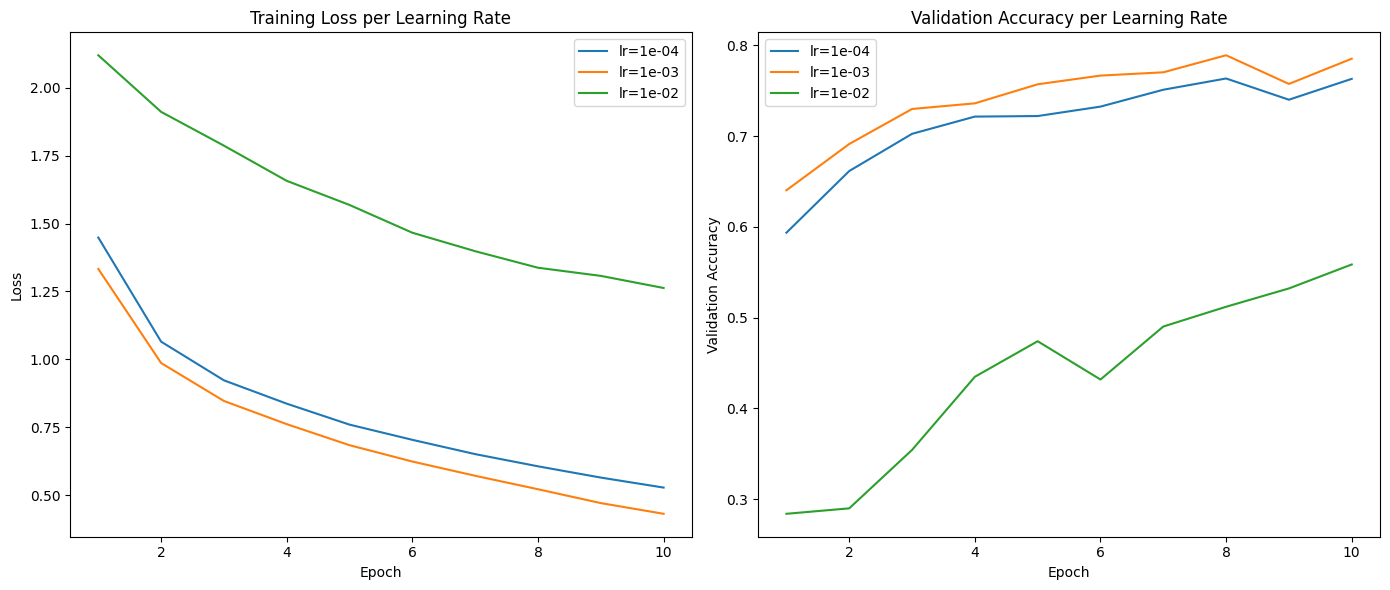

In [48]:
print(f"Showing the history of the training for the best learning rate for the model ModelCNNProposal1")

# Plotting the results using matplotlib

# Convert history to numpy arrays for easier plotting
history['lr'] = np.array(history['lr'])
history['epoch'] = np.array(history['epoch'])
history['loss'] = np.array(history['loss'])
history['val_accuracy'] = np.array(history['val_accuracy'])

# Create a plot for loss and validation accuracy
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
for lr in learning_rates:
    lr_mask = history['lr'] == lr
    plt.plot(history['epoch'][lr_mask], history['loss'][lr_mask], label=f'lr={lr:.0e}')
plt.title('Training Loss per Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracy Plot
plt.subplot(1, 2, 2)
for lr in learning_rates:
    lr_mask = history['lr'] == lr
    plt.plot(history['epoch'][lr_mask], history['val_accuracy'][lr_mask], label=f'lr={lr:.0e}')
plt.title('Validation Accuracy per Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/20, Loss: 1.3366, Train Accuracy: 0.6645, Val Accuracy: 0.6508
Epoch 2/20, Loss: 0.9846, Train Accuracy: 0.7179, Val Accuracy: 0.6998
Epoch 3/20, Loss: 0.8523, Train Accuracy: 0.7529, Val Accuracy: 0.7296
Epoch 4/20, Loss: 0.7587, Train Accuracy: 0.7858, Val Accuracy: 0.7474
Epoch 5/20, Loss: 0.6880, Train Accuracy: 0.8196, Val Accuracy: 0.7706
Epoch 6/20, Loss: 0.6290, Train Accuracy: 0.8286, Val Accuracy: 0.7708
Epoch 7/20, Loss: 0.5664, Train Accuracy: 0.8654, Val Accuracy: 0.7880
Epoch 8/20, Loss: 0.5201, Train Accuracy: 0.8754, Val Accuracy: 0.7868
Epoch 9/20, Loss: 0.4689, Train Accuracy: 0.8870, Val Accuracy: 0.7920
Epoch 10/20, Loss: 0.4321, Train Accuracy: 0.9037, Val Accuracy: 0.8000
Epoch 11/20, Loss: 0.3923, Train Accuracy: 0.9141, Val Accuracy: 0.7942
Epoch 12/20, Loss: 0.3582, Train Accuracy: 0.9240, Val Accuracy: 0.7932
Epoch 13/20, Loss: 0.3316, Train Accuracy: 0.9340, Val Accuracy: 0.7924
Epoch 14/20, Loss: 0.3068, Train Accuracy: 0.9407, Val Accuracy: 0.7998
E

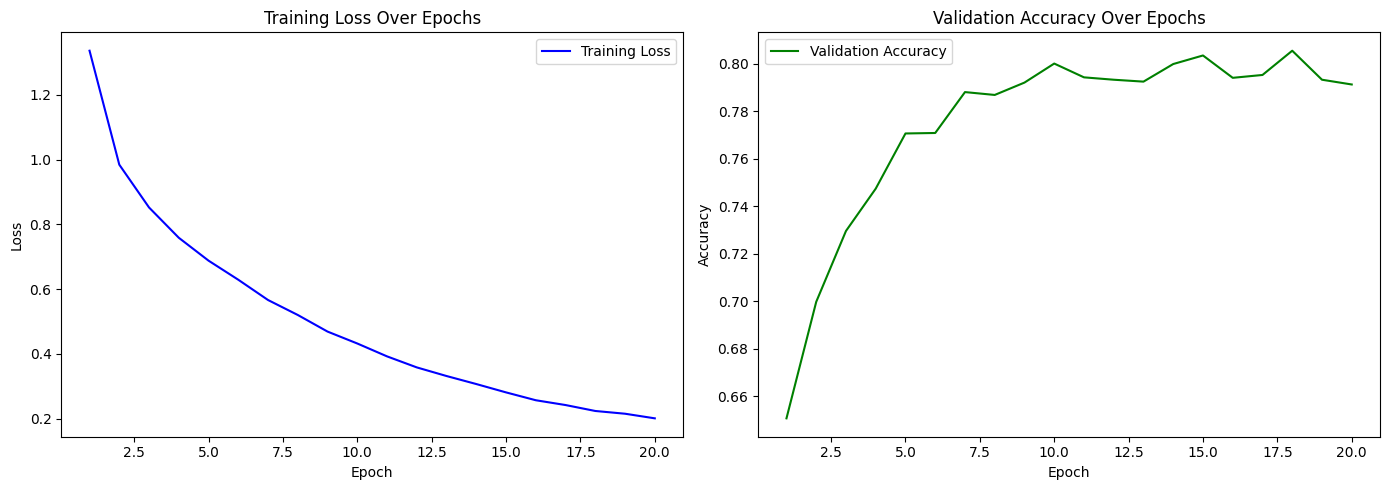

In [49]:
# Setup random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

modelCNN1 = ModelCNNProposal1()
optimiser = torch.optim.Adam(modelCNN1.parameters(), lr=best_result['lr'])
epochs = 20

train(modelCNN1, optimiser, epochs)

In [50]:
# Try 2 with a different model

# Model 2

class ModelCNNProposal2(nn.Module):
    def __init__(self):
        super().__init__()
        
        channel1 = 16
        channel2 = 32
        channel3 = 64
        channel4 = 128

        # First block: Conv -> BatchNorm -> ReLU -> Conv -> BatchNorm -> ReLU -> MaxPool
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=channel1, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel1),
            nn.ReLU(),
            nn.Conv2d(in_channels=channel1, out_channels=channel2, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Second block: Conv -> BatchNorm -> ReLU -> Conv -> BatchNorm -> ReLU -> MaxPool
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=channel2, out_channels=channel3, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel3),
            nn.ReLU(),
            nn.Conv2d(in_channels=channel3, out_channels=channel4, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel4),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Fully connected layer
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=8*8*channel4, out_features=10)
        )

    def forward(self, x):
        x = self.block1(x)  # First block forward pass
        x = self.block2(x)  # Second block forward pass
        x = self.fc(x)  # Fully connected layer forward pass
        return x

In [51]:
# Define the grid of hyperparameters
learning_rates = [1e-4, 1e-3, 1e-2]

best_result, history = grid_search(learning_rates, ModelCNNProposal2)

print(f"Best Hyperparameters for the model ModelCNNProposal2: {best_result['lr']:.0e}")

Training [1/3]: lr=1e-04
Epoch [1], Loss: 1.3444, Val Accuracy: 0.6214
Epoch [2], Loss: 0.9646, Val Accuracy: 0.6592
Epoch [3], Loss: 0.8258, Val Accuracy: 0.7022
Epoch [4], Loss: 0.7360, Val Accuracy: 0.7090
Epoch [5], Loss: 0.6692, Val Accuracy: 0.7172
Epoch [6], Loss: 0.6145, Val Accuracy: 0.7222
Epoch [7], Loss: 0.5543, Val Accuracy: 0.7230
Epoch [8], Loss: 0.5096, Val Accuracy: 0.7228
Epoch [9], Loss: 0.4670, Val Accuracy: 0.7404
Epoch [10], Loss: 0.4254, Val Accuracy: 0.7338
Training [2/3]: lr=1e-03
Epoch [1], Loss: 1.3496, Val Accuracy: 0.6678
Epoch [2], Loss: 0.8606, Val Accuracy: 0.6962
Epoch [3], Loss: 0.7154, Val Accuracy: 0.7490
Epoch [4], Loss: 0.6198, Val Accuracy: 0.7474
Epoch [5], Loss: 0.5369, Val Accuracy: 0.7746
Epoch [6], Loss: 0.4685, Val Accuracy: 0.7794
Epoch [7], Loss: 0.3922, Val Accuracy: 0.7704
Epoch [8], Loss: 0.3309, Val Accuracy: 0.7740
Epoch [9], Loss: 0.2683, Val Accuracy: 0.7838
Epoch [10], Loss: 0.2128, Val Accuracy: 0.7830
Training [3/3]: lr=1e-02
Epo

Showing the history of the training for the best learning rate for the model ModelCNNProposal2


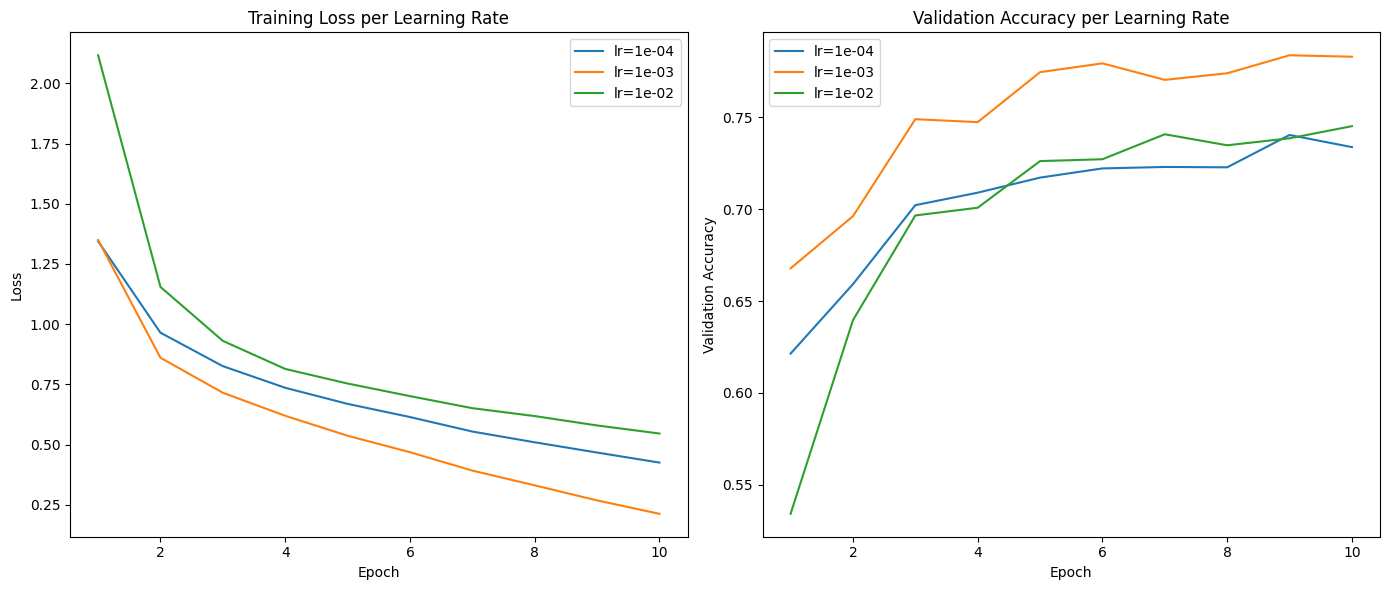

In [52]:
print(f"Showing the history of the training for the best learning rate for the model ModelCNNProposal2")

# Plotting the results using matplotlib

# Convert history to numpy arrays for easier plotting
history['lr'] = np.array(history['lr'])
history['epoch'] = np.array(history['epoch'])
history['loss'] = np.array(history['loss'])
history['val_accuracy'] = np.array(history['val_accuracy'])

# Create a plot for loss and validation accuracy
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
for lr in learning_rates:
    lr_mask = history['lr'] == lr
    plt.plot(history['epoch'][lr_mask], history['loss'][lr_mask], label=f'lr={lr:.0e}')
plt.title('Training Loss per Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracy Plot
plt.subplot(1, 2, 2)
for lr in learning_rates:
    lr_mask = history['lr'] == lr
    plt.plot(history['epoch'][lr_mask], history['val_accuracy'][lr_mask], label=f'lr={lr:.0e}')
plt.title('Validation Accuracy per Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/20, Loss: 1.3494, Train Accuracy: 0.6881, Val Accuracy: 0.6724
Epoch 2/20, Loss: 0.8650, Train Accuracy: 0.7469, Val Accuracy: 0.7136
Epoch 3/20, Loss: 0.7169, Train Accuracy: 0.7991, Val Accuracy: 0.7536
Epoch 4/20, Loss: 0.6160, Train Accuracy: 0.8130, Val Accuracy: 0.7562
Epoch 5/20, Loss: 0.5359, Train Accuracy: 0.8635, Val Accuracy: 0.7858
Epoch 6/20, Loss: 0.4611, Train Accuracy: 0.8746, Val Accuracy: 0.7836
Epoch 7/20, Loss: 0.3951, Train Accuracy: 0.8775, Val Accuracy: 0.7784
Epoch 8/20, Loss: 0.3264, Train Accuracy: 0.9174, Val Accuracy: 0.7918
Epoch 9/20, Loss: 0.2702, Train Accuracy: 0.9277, Val Accuracy: 0.7836
Epoch 10/20, Loss: 0.2125, Train Accuracy: 0.9420, Val Accuracy: 0.7836
Epoch 11/20, Loss: 0.1734, Train Accuracy: 0.9525, Val Accuracy: 0.7786
Epoch 12/20, Loss: 0.1371, Train Accuracy: 0.9618, Val Accuracy: 0.7948
Epoch 13/20, Loss: 0.1157, Train Accuracy: 0.9652, Val Accuracy: 0.7928
Epoch 14/20, Loss: 0.1012, Train Accuracy: 0.9660, Val Accuracy: 0.7820
E

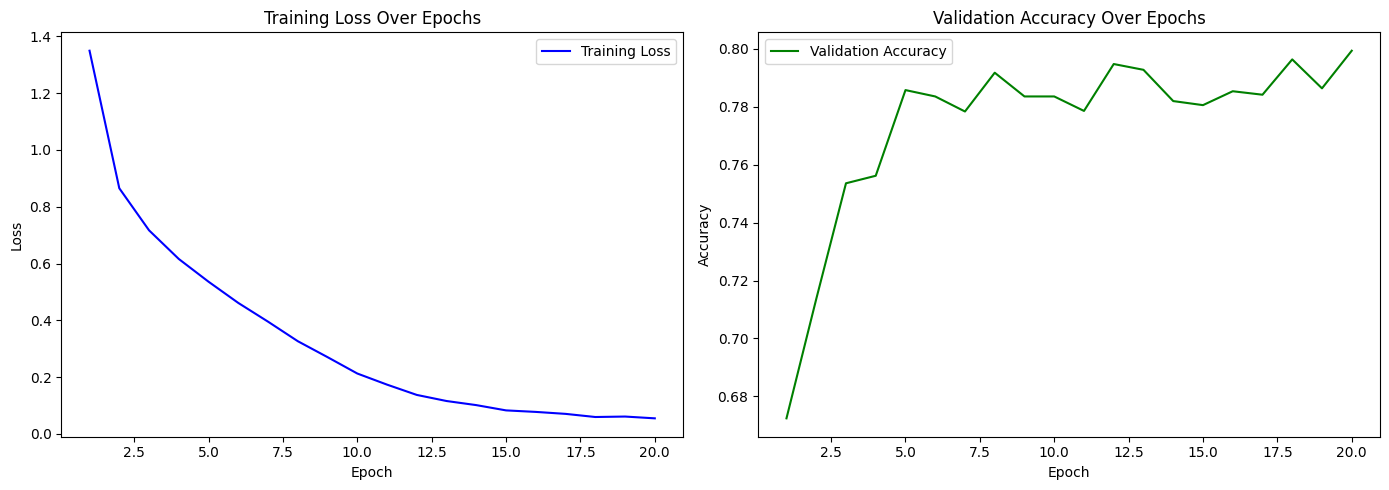

In [53]:
# Setup random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

modelCNN2 = ModelCNNProposal2()
optimiser = torch.optim.Adam(modelCNN2.parameters(), lr=best_result['lr'])
epochs = 20

train(modelCNN2, optimiser, epochs)

### Conclution

The dataset selected for this activity is the CIFAR10 dataset, which is a collection of 60,000 32x32 color images in 10 different classes. The classes include airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. The dataset is divided into 50,000 training images, 5,000 validation images, and 5,000 testing images. The images are normalized and centered around the mean and standard deviation of the dataset.

The learning rate selection was based on the results of the grid search function. The results shown above indicate that the learning rate of 1e-3 is the best choice for this model. The model was trained for 20 epoch, a batch size of 64 